# ID2222 Data Mining, Homework 1 
# **Finding Similar Items: Textually Similar Documents**

Brando Chiminelli, Tommaso Praturlon

November 14th, 2022

The goal of this notebook is to implement the stages of finding textually similar
documents based on Jaccard similarity and an estimation of it.
In particular, the following techniques are addressing the problem by appying
the functions one after the other, like in a pipeline.
These functions are called, in order, Shingling, MinHashing,
and Locality-Sensitive Hashing (LSH).

## Import Libraries and read a sample from the file

We are reading a sample of 100 documents (article texts) from a dataset of news articles available
on Kaggle (https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset).
In order to run this notebook you need to import the dataset in the same directory
of this notebook.
Here, we are also dropping any possible duplicates because this would alter the similarity analysis.

In [55]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

PATH_TO_DATA = "True.csv"
df = pd.read_csv(PATH_TO_DATA)
print("Data read successfully!")
# Delete duplicates from the dataset in the columns title and text
df.drop_duplicates(subset=['text'], keep='first', inplace=True)

NUM_OF_DOCS = 100
print("Number of documents: ")
print(NUM_OF_DOCS)

# Select random documents from the dataset
data_ls = random.sample(list(df['text']),NUM_OF_DOCS)

Data read successfully!
Number of documents: 
100


## Shingling

The following two functions are implementing the first stage of our pipeline: **Shingling**

A document is divided into sequences of characters of length k, called shingles. A document is then the set of its k-shingles. The underlying assumption is that documents with lots of shingles in common are similar. This similarity can be identified with the Jaccard Similarity rule.

When shingles are long, their length can be reduced using hash functions, thus representing the document with the set of its hash values for those k-shingles.

This is performed in the following two functions. The first, given a text document, returns a set of its hashed shingles.

With the function list_shingles(), we are building the list of sets of hashed shingles for each document.

In [56]:
K_SHINGLE = 5

def shingles(doc, k=K_SHINGLE):
    '''
    Description: takes a document as input and returns a set of the shingles for that document.
    shingles_ch are the hashed shingles using built-in hash()
    shingles_c are only characters
    '''
    shingles_hash = [hash(doc[i: i+k]) for i in range(len(doc) - k + 1)]

    return set(shingles_hash)


In [57]:
def list_shingles(doc_ls, k=K_SHINGLE):
    '''
    Description: takes as input all the documents as a list and returns a list of
    all hased shingles for each document.
    '''
    shingle_list = [] # list of sets of hashed shingles for each document
    for doc in doc_ls:
        s_hash = shingles(doc,k)
        shingle_list.append(s_hash)

    return shingle_list


In [58]:
shingles_list = list_shingles(data_ls)

### Compare two sets of shingles using Jaccard Similarity

The next function computes the Jaccard Similarity of two set of hashed shingles by dividing the cardinality of the intersection of two sets for the cardinality of their union.

In [59]:
def jaccard_similarity(set1, set2):

    intersection = len(list(set1.intersection(set2)))
    union = (len(set1) + len(set2)) - intersection

    return float(intersection) / union

Now we want to print out a matrix of the similarities to get an overall view of our dataset, the main diagonal will of course be all ones as we are computing the comparison of two sets that are the same.

In [60]:
# Create the Similarity Matrix, storing the percentage of similarity document by document
simil_mat = np.zeros((len(shingles_list),len(shingles_list)))
# Compute the Jaccard Similarity
total = 0
for i in range(len(shingles_list)):
    for j in range(len(shingles_list)):
      simil_mat[i,j] = jaccard_similarity(shingles_list[i],shingles_list[j])
      if i==j: simil_mat[i,j] = 0 # to remove ones in diagonal
      if simil_mat[i,j]>=0.15: total +=1

total = total/2
print(simil_mat)
print("Total", total)


[[0.         0.11557569 0.121065   ... 0.04416404 0.0832552  0.03402367]
 [0.11557569 0.         0.11205322 ... 0.03642384 0.09419513 0.02487352]
 [0.121065   0.11205322 0.         ... 0.03898188 0.09044815 0.03273669]
 ...
 [0.04416404 0.03642384 0.03898188 ... 0.         0.02873939 0.08635795]
 [0.0832552  0.09419513 0.09044815 ... 0.02873939 0.         0.02876712]
 [0.03402367 0.02487352 0.03273669 ... 0.08635795 0.02876712 0.        ]]
Total 1.0


## MinHashing

The following two function are implementing the second stage of our pipeline: **MinHashing**

The idea is to compute, for each set (shingles) inside shingles_list, the hash function for each shingle in the set and take the one with minimum value.

This is performed in the class minhash, which, given the list of shingles and the number of hash functions (k), returns a matrix, where for each different hash function (one different applied in every row) we take the minimum hashes via the hash function h(x) = (x*a + b)%c for every set of shingles and we do that for every element of the shingles_list so for every document (columns). 

In the hashFunction, a and b are random numbers and c is the maximum prime integer representable in 32 bits.

The matrix that is return is called signatures because it is the signature matrix where each column is the signature of one document. In this way we have compressed the shingles matrix and we can compute the similarity, which will be an estimation of the Jaccard similarity we saw before, but will be of a lower complexity, depending on the number of hash function applied.


In [61]:
K_MINHASH = 100 # number of hash functions

def hashFunction(k):
    '''
    Creates the coefficients for the hash function
    h(x) = (ax+b)%c
    '''
    a = np.random.rand(k)
    b = np.random.rand(k)
    c = 4294967311 # maximum prime integer

    return a,b,c # a,b are arrays of rand number between [0, 1]

In [62]:
def minhash(shingles_list, k=K_MINHASH):
    '''
    Takes as input a list of hashed shingles and returns the Signature Matrix.
    '''
    # Signature Matrix, rows: k hash functions,
    # cols: list of sets of hashed shingles for each document
    signatures_mat = np.zeros((k, len(shingles_list)))
    a, b, c = hashFunction(k)
    # print(a,b,c)

    # for every hash function
    for h_fun in range(k):
      # for every set of shingles in the list of all shingles
      for shingles in shingles_list:
        # apply the same hash function to every set of shingles (to every document's shingles)
        hashCode = map(lambda shingle: (shingle*a[h_fun] + b[h_fun])%c, shingles)
        minHashCode = min(hashCode) # take the minimum value for that set of hashed shingles
        # build Signature Matrix, row: same hash function,
        # cols: minimum value for that set at its index inside the list
        signatures_mat[h_fun, shingles_list.index(shingles)] = minHashCode

    return signatures_mat

In [63]:
signatures_mat = minhash(shingles_list)
print(signatures_mat)

[[ 2105372.     2464650.      472966.    ...  3095236.      268194.
   7364315.   ]
 [ 2625422.      644805.     1334814.    ...   857216.      144618.
   1178718.   ]
 [  190437.      139531.      905471.    ...  3973761.       26707.
   5847357.   ]
 ...
 [ 2016939.     2544450.     2016939.    ...  3704255.     3434890.
   3704255.   ]
 [ 1359229.     1671297.     1243601.    ...  2017131.     2017131.
    790885.   ]
 [ 1364675.      363495.      985695.125 ... 11195139.      774482.
     52769.   ]]


### Compare two sets of signatures, estimation of Jaccard Similarity

As anticipated, in the next funtion we are computing the estimation of the Jaccard similarity between pairs of signatures. We can tell from the output printed that we have a decrease in accuray from the comparison between pairs of shingles, but this also comes with an improve in the performance.

In [64]:
def compare_signatures(signature1, signature2, k=K_MINHASH):
    '''
    signature1 is a set of minhashed shingles of the first document we want to compare
    k is the number of minhash functions used so the number of rows in the signature matrix
    the comparison of signatures is an estimation of jaccard similarity
    '''
    intersection = len(list(signature1.intersection(signature2)))

    return float(intersection) / k

In [65]:
# Build Similarity Matrix for signatures
simil_mat_sign = np.zeros((len(signatures_mat),len(signatures_mat)))

tot_signature = 0
# Compare each minHashed value from the same function with all others in same row
for i in range(len(signatures_mat)):
    for j in range(len(signatures_mat)):
      simil_mat_sign[i,j] = compare_signatures(set(signatures_mat[:,i]),set(signatures_mat[:,j]), K_MINHASH)
      if i==j: simil_mat_sign[i,j] = 0 # to remove ones in diagonal
      if simil_mat_sign[i,j]>=0.15: tot_signature +=1

tot_signature = tot_signature/2
print("Total similar signatures:", tot_signature)
print("Compared Signatures")
print(simil_mat_sign)

Total similar signatures: 16.0
Compared Signatures
[[0.   0.13 0.1  ... 0.02 0.05 0.03]
 [0.13 0.   0.07 ... 0.01 0.11 0.02]
 [0.1  0.07 0.   ... 0.02 0.03 0.  ]
 ...
 [0.02 0.01 0.02 ... 0.   0.02 0.11]
 [0.05 0.11 0.03 ... 0.02 0.   0.04]
 [0.03 0.02 0.   ... 0.11 0.04 0.  ]]


## Locality-Sensitive Hashing

The third part of the implementation consists in Locality-Sensitive Hashing. Function band_hashing() creates the bands, get_bucket_list() creates the list of buckets, query_band_hashing() makes a list of hash functions for each bucket and find_similar_docs() uses the previous functions to find similar documents using LSH.

In [66]:
def band_hashing(band, hash_f, buckets_dict):
    '''
    This function takes a band as input,
    hashes it and puts it in the buckets_list
    at its respective postition.
    buckets_dict is a dictionary with key: the hash value, and value: the indexes of the col
    band is a portion of data frame, restricted to b number of rows 
    '''
    
    #cycle through every band of each document and hash the values
    for col in band.columns:
        h = hash_f(tuple(band[col].values))
        if h in buckets_dict: 
            buckets_dict[h].append(col)
        else:
            buckets_dict[h] = [col]


In [67]:
def get_bucket_list(sign_mat, r, hash_f=None):
    '''
    This function returns the list of buckets with similar documents
    This function generates the list of dictionaries objects where
    each band is hashed to a bucket in a dictionary.

    Parameters
    ----------
    sign_mat: pandas.Dataframe
        signatures of all the documents generated from minhashing
    r: int
        no of rows in each band
    hash_f: function, optional
        hash function used to hash document to buckets
    Returns
    -------
    buckets_list: a list of dictionaries. Each dictionary
        contains hashes of column vectors of the band as keys
        and the list of documents as values.
    '''
    # b: number of bands
    # n: length of a document signature = numebr of minhash functions used
    # r: number of rows in a band
    n = sign_mat.shape[0]
    b = n//r # floor division
    buckets_list = [dict() for i in range(b)] #create a list of b dictionaries

    if hash_f == None:
        hash_f = hash

    for i in range(0, n-r+1, r): #r is the step
        band = sign_mat.loc[i:i+r-1,:] # access group of rows
        #print(buckets_list)
        band_hashing(band, hash_f, buckets_list[int(i/r)])

    return buckets_list

In [68]:
def query_band_hashing(band, hash_f):
    '''
    This function takes a band of query document as input,
    hashes it and puts it in the buckets_list
    at its respective postition.
    '''

    hash_list = []
    h = hash_f(tuple(band.values))
    hash_list.append(h)

    return hash_list

In [69]:
def find_similar_docs(doc_id, buckets_list, sign_mat, r, hash_f=None):
    '''
    This function finds similar documents
    Parameters
    ----------
    buckets_list: list
        list of dictionary objects generated by get_bucket_list
    hash_f: function, optional
        the same hash function used for get_bucket_list

    Returns
    -------
    set
        set containing similar documents to given document
        ADD SIMILARITY THRESHOLD
    '''

    # b: number of bands
    # n: length of a document signature
    # r: number of rows in a band
    n = sign_mat.shape[0]
    b = n//r

    if hash_f == None:
        hash_f = hash

    query_bucket_list = []

    for i in range(0, n-r+1, r):
        band = sign_mat.loc[i:i+r-1, int(doc_id)]
        query_bucket_list.append(query_band_hashing(band, hash_f))

    similar_docs = set()
    for i in range(len(query_bucket_list)):
        for j in range(len(query_bucket_list[i])):
            similar_docs.update(set(buckets_list[i][query_bucket_list[i][j]]))

    return similar_docs # list of similar documents

In [70]:
cols = [] # get the indexes of colums for the new data frame
for i in range(len(signatures_mat)):
    cols.append(i)

df_signatures = pd.DataFrame(signatures_mat, columns = cols) # convert Signatures Matrix to a data frame

#bucket list is the list of dict() with key: hashed band value and value: index of docs
buckets_list = get_bucket_list(df_signatures, 5) #5 is the number of rows in the band

doc_id = 2
# gives out the set of documents id that are similar to the one we pass in d
find_similar_docs(doc_id, buckets_list, df_signatures, 5)

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
[{1400879491568324239: [0], -6887858184666233821: [1], -2367915444428366261: [2], 5895316732202233091: [3], -2483514415042520167: [4], 6656633114144838474: [5], -2004927967109355256: [6], -2498183862571090689: [7], 7533417153671055454: [8], 2730734911886886307: [9], -6974949268316767825: [10], 1124601119156807709: [11], -2594220888904558253: [12], -2131709211183779124: [13], -2480197925823757687: [14], 4121816205647747320: [15], -1799114612980582305: [16], 6020885418618242524: [17], -1160588805552572705: [18], 8580700230193969747: [19], 5444215224585861490: [20], 7121242492090579970: [21], -3826710811686446292: [22], -2797979608771258687: [23], 3484505066044860367: [24], -323641271835103388: [25], 7888058337162625418: [26], -8410613636041805455: [27], 1287467315610011850: [28], -2709321446231239011: [29], -4553455386694549236: [30], 610296406993528974: [31], -3209312475577696849: [32], -8403648977870261631

{2}

## Performance Analysis

Here the intention is to test and evaluate the implementation's scalability (the execution time versus the size of the input dataset).
The similarity threshold is set to 0.14 and it is empirically obtained since the similarities in the dataset are low above 10%.

The execution time of every function will be considered and plotted in the graph. 

In [71]:
# For cycle iterating a vector of N documents
# Calling various functions
# Saving each function duration in its vector of times
# Plot these vectors versus the number of documents.

n_of_docs = [10, 100, 500, 1000]

### Shingling Class

In [72]:
# For Shingling class methods
t_shin_jacc_sim = np.zeros(len(n_of_docs))

for index in range(len(n_of_docs)):
  # start timer
  t_start = time.time()
  n_docs = n_of_docs[index]
  # Get n_docs documents from the datase
  data_ls = random.sample(list(df['text']),n_docs)
  # Computes shingles
  shingles_list = list_shingles(data_ls)
  # Create the Similarity Matrix, storing the percentage of similarity document by document
  simil_mat = np.zeros((n_docs,n_docs))
  # Count similar documents
  total = 0
  # Compute the Jaccard Similarity
  for i in range(n_docs-1):
    for j in range(n_docs-1):
      simil_mat[i,j] = jaccard_similarity(shingles_list[i],shingles_list[j])
      if i==j: simil_mat[i,j] = 0 # to remove ones in diagonal
      if simil_mat[i,j]>=0.14: total +=1
  t_stop = time.time() - t_start
  t_shin_jacc_sim[index] = t_stop

  print("---\nNumber of documents: ", n_docs, "\nSimilar documents: ", total, "\nTime spent: ", t_stop)

---
Number of documents:  10 
Similar documents:  0 
Time spent:  0.014716863632202148
---
Number of documents:  100 
Similar documents:  8 
Time spent:  0.49268484115600586
---
Number of documents:  500 
Similar documents:  364 
Time spent:  11.429971933364868
---
Number of documents:  1000 
Similar documents:  932 
Time spent:  43.73190784454346


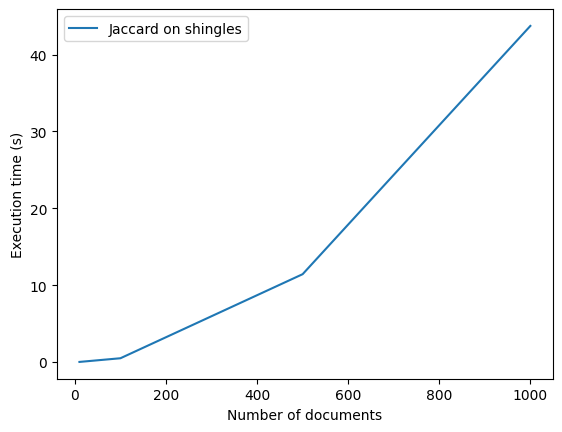

In [73]:
# Plot
plt.plot(n_of_docs, t_shin_jacc_sim, label='Jaccard on shingles')
plt.xlabel('Number of documents')
plt.ylabel('Execution time (s)')
plt.legend()
plt.show()

### MinHashing Class

In [74]:
# For MinHashing
t_minh_jacc_sim = np.zeros(len(n_of_docs))

for index in range(len(n_of_docs)):
  # start timer
  t_start = time.time()
  n_docs = n_of_docs[index]
  # Get n_docs documents from the datase
  data_ls = random.sample(list(df['text']),n_docs)
  # Compute shingles
  shingles_list = list_shingles(data_ls)
  # Computes signature matrix
  signatures_mat = minhash(shingles_list)
  # Create the Similarity Matrix, storing the percentage of similarity document by document
  simil_mat = np.zeros((n_docs,n_docs))
  # Count similar documents
  total = 0
  # Compute the Jaccard Similarity
  for i in range(n_docs-1):
    for j in range(n_docs-1):
      simil_mat_sign[i,j] = compare_signatures(set(signatures_mat[:,i]),set(signatures_mat[:,j]), K_MINHASH)
      if i==j: simil_mat[i,j] = 0 # to remove ones in diagonal
      if simil_mat[i,j]>=0.14: total +=1
  t_stop = time.time() - t_start
  t_minh_jacc_sim[index] = t_stop

  print("Number of documents: ", n_docs, "\nSimilar documents: ", total, "\nTime spent: ", t_stop)

Number of documents:  10 
Similar documents:  0 
Time spent:  0.5965878963470459
Number of documents:  100 
Similar documents:  0 
Time spent:  6.520467281341553


IndexError: index 100 is out of bounds for axis 1 with size 100

In [ ]:
# For LSH
t_lsh_jacc_sim = np.zeros(len(n_of_docs))

In [ ]:
# Graphs